In [19]:
import optuna
import numpy as np
import pandas as pd

from sklearn.datasets import make_blobs, make_moons
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering, MeanShift, estimate_bandwidth
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_mutual_info_score as AMI
from rock import ROCK

from util import dbscan_init

import logging
import sys

In [20]:
seed = 0
n_samples = 1000
jitter = 15 * 0.01
datasets = []

jitter_grid = [1, 5, 10, 15, 20, 25, 30]
n_samples_grid = [50, 100, 200, 400, 800, 1600]

In [21]:
experiment = []
n_centers = 2
rock_results = []
other_results = []

In [22]:
for n in n_samples_grid:
    step = 0
    for s in range(seed, seed+10):
        #print(f'jitter: {j}, seed: {s}')
        dataset = make_moons(n_samples=n, noise=jitter, shuffle=True, random_state=s) 
        run = {}
        run['step'] = step
        run['n_samples'] = n
        run['n_centers'] = n_centers
        run['jitter'] = jitter
        scaler = StandardScaler()
        data = scaler.fit_transform(dataset[0])
        if n_centers:
            kmeans = KMeans(n_clusters=n_centers, random_state=seed).fit(data).labels_
        elif dataset_name == 'moons':
            kmeans = KMeans(n_clusters=2, random_state=seed).fit(data).labels_
            run['k'] = 2
        eps, min_pts = dbscan_init(data)
        eps, min_pts = (0.2, 4)
        dbscan = DBSCAN(eps=eps, min_samples=min_pts).fit(data).labels_
        run['eps'] = eps
        run['min_pts'] = min_pts
        spectral = SpectralClustering(n_clusters=2).fit(data).labels_
        bandwidth = estimate_bandwidth(data)

        run['bandwidth'] = bandwidth
        mean_shift = MeanShift(bandwidth=bandwidth).fit(data).labels_

        rock = ROCK(tmax=15).fit(data).labels_

        gt = dataset[1]
        rock_results.append(AMI(rock, gt))
        other_results.append(np.max([AMI(kmeans, gt), AMI(dbscan, gt), AMI(spectral, gt), AMI(mean_shift, gt)]))

        run['ROCK'] = AMI(rock, gt)
        run['K_MEANS'] = AMI(kmeans, gt)
        run['DBSCAN'] = AMI(dbscan, gt)
        run['SPECTRAL'] = AMI(spectral, gt)
        run['MEAN_SHIFT'] = AMI(mean_shift, gt)

        step += 1

        experiment.append(run)

In [28]:
pd.DataFrame(experiment).to_csv('two_moons_analysis_samples.csv')

In [55]:
mean_std = pd.DataFrame(experiment).groupby('n_samples')[['ROCK', 'DBSCAN', 'K_MEANS', 'SPECTRAL', 'MEAN_SHIFT']].agg([np.mean, np.std])

AttributeError: 'Line2D' object has no property 'y_err'

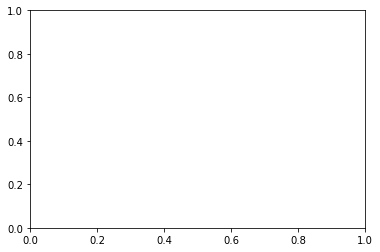

In [77]:
mean_std['ROCK', 'mean'].plot(y_err=mean_std['ROCK', 'std'])
mean_std['DBSCAN', 'mean'].plot(y_err=mean_std['DBSCAN', 'std'])
mean_std['K_MEANS', 'mean'].plot(y_err=mean_std['K_MEANS', 'std'])
mean_std['SPECTRAL', 'mean'].plot(y_err=mean_std['SPECTRAL', 'std'])
mean_std['MEAN_SHIFT', 'mean'].plot(y_err=mean_std['MEAN_SHIFT', 'std'])

In [50]:
mean_std.columns

MultiIndex([(      'ROCK', 'mean'),
            (      'ROCK',  'std'),
            (    'DBSCAN', 'mean'),
            (    'DBSCAN',  'std'),
            (   'K_MEANS', 'mean'),
            (   'K_MEANS',  'std'),
            (  'SPECTRAL', 'mean'),
            (  'SPECTRAL',  'std'),
            ('MEAN_SHIFT', 'mean'),
            ('MEAN_SHIFT',  'std')],
           )

In [56]:
mean_std

ROCK              DBSCAN             K_MEANS            \
               mean       std      mean       std      mean       std   
n_samples                                                               
50         0.466895  0.174167  0.029631  0.047711  0.359466  0.032654   
100        0.574158  0.192551  0.197100  0.027436  0.376870  0.040898   
200        0.608674  0.140164  0.320764  0.025124  0.363208  0.028559   
400        0.582618  0.118339  0.521877  0.242418  0.385772  0.027437   
800        0.669777  0.142734  0.008408  0.010935  0.373233  0.013288   
1600       0.575522  0.205370  0.000463  0.001713  0.376980  0.013121   

           SPECTRAL           MEAN_SHIFT            
               mean       std       mean       std  
n_samples                                           
50         0.380484  0.035559   0.368888  0.070300  
100        0.429027  0.044501   0.426870  0.044919  
200        0.407853  0.022312   0.419761  0.022907  
400        0.424790  0.022181   0.433587  0.031640  
800        0.416695  0.014721   0.427072  0.012882  
1600       0.418148  0.008792   0.428422  0.008173

In [57]:
import matplotlib.pyplot as plt

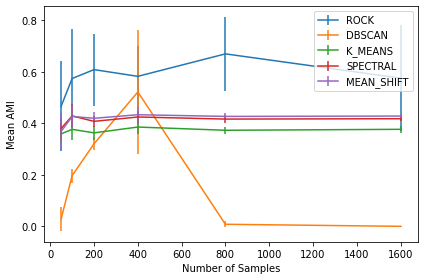

In [102]:
plt.errorbar(mean_std.index, mean_std['ROCK']['mean'], yerr=mean_std['ROCK']['std'])
plt.errorbar(mean_std.index, mean_std['DBSCAN']['mean'], yerr=mean_std['DBSCAN']['std'])
plt.errorbar(mean_std.index, mean_std['K_MEANS']['mean'], yerr=mean_std['K_MEANS']['std'])
plt.errorbar(mean_std.index, mean_std['SPECTRAL']['mean'], yerr=mean_std['SPECTRAL']['std'])
plt.errorbar(mean_std.index, mean_std['MEAN_SHIFT']['mean'], yerr=mean_std['MEAN_SHIFT']['std'])

plt.legend(['ROCK', 'DBSCAN', 'K_MEANS', 'SPECTRAL', 'MEAN_SHIFT'])
plt.xlabel('Number of Samples')
plt.ylabel('Mean AMI')
plt.tight_layout()
plt.savefig('two_moons_num_samples.png')

ValueError: The lengths of the data (6) and the error 4 do not match

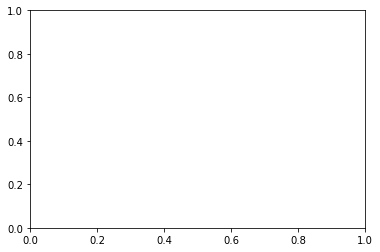

In [49]:
mean_std[['SPECTRAL', 'ROCK']].plot(yerr=[('ROCK', 'std'), ('SPECTRAL', 'std')])

In [25]:
from matplotlib import pyplot

In [26]:
colors = ['red', 'green']

In [27]:
pyplot.scatter(x=datasets[3][0][:, 0], y=datasets[3][0][:, 1], marker='.', c=datasets[3][1])

IndexError: list index out of range

In [ ]:
np.mean(np.array(rock_results) - np.array(other_results))

In [ ]:
np.mean(rock_results) - np.mean(other_results)